# **Israel Elections Data Analysis**

An example notebook showing how to read and display the Israel 2021 elections results. This is the notebook for the first week.

In [121]:
# Add a check if we run in google colab or locally in jupyter notebook
run_in_colab = False
if 'google.colab' in str(get_ipython()):
    run_in_colab = True
    print('Running on CoLab')
else:
    print('Running locally on Jupyter')



Running on CoLab


In [122]:
# First install tha needed packages using conda in the current Jupyter kernel
# Run once - should take a long time!
import sys
#if not(run_in_colab):
#  !conda install --yes --prefix {sys.prefix} numpy
#  !conda install --yes --prefix {sys.prefix} pandas
#  !conda install --yes --prefix {sys.prefix} matplotlib
#  !conda install --yes --prefix {sys.prefix} statsmodels  # statistical modelling 
#  !conda install --yes --prefix {sys.prefix} xlrd  # read excel 



# Alternatively, if your python wasn't installed using anaconda, we can use pip install: 
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install pandas
# !{sys.executable} -m pip install matplotlib


In [123]:
# Import modules 
import numpy as np  # a module for working with numerical array 
import pandas as pd  # a module for working with data-frames
import statsmodels.api as sm  # a module for statistical modelling (e.g. regression analysis)

First, we need to mount our local drive to the colab network

In [124]:
# Mount drive in google colab
if run_in_colab:
    from google.colab import drive
    drive.mount('/content/drive')
else:  # Set local path 
    data_path = "/Users/elkysandor/Desktop/huji yr3/static lab/"  


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [125]:
# Loading elections 2021 elections data:
if run_in_colab:
    from google.colab import files
    uploaded = files.upload()

Saving election_2020.csv to election_2020 (1).csv
Saving eshkol_hevrati_calcali.csv to eshkol_hevrati_calcali (1).csv
Saving votes per ballot 2021.csv to votes per ballot 2021 (1).csv
Saving votes per city 2021.csv to votes per city 2021 (1).csv


In [126]:
import io

data_type = "city" # "ballot"  # city
if   run_in_colab:
    df_2021_raw = pd.read_csv(io.BytesIO(uploaded['votes per city 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
else:  # read local file
    if data_type == "ballot":
        df_2021_raw = pd.read_csv(data_path + 'votes per ballot 2021.csv',  encoding = 'iso-8859-8', index_col='שם ישוב')
        # preprocessing of ballot
        df_2021 = df_2021_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
        df_2021 = df_2021[df_2021.columns[8:-1]] # removing "metadata" columns
    else:
        df_2021_raw = pd.read_csv(data_path + 'votes per city 2021.csv',  encoding = 'iso-8859-8', index_col='שם ישוב')
        # preprocessing of cities 
        df_2021 = df_2021_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
        df_2021 = df_2021[df_2021.columns[5:-1]] # removing "metadata" columns
# Dataset is now stored in a Pandas Dataframe

In [127]:
df_2021 = df_2021_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
df_2021 = df_2021[df_2021.columns[5:-1]] # removing "metadata" columns
print("{} votes in March 2021".format(df_2021_raw['כשרים']['מעטפות חיצוניות']) + ' מעטפות חיצוניות ')

421619 votes in March 2021 מעטפות חיצוניות 


In [128]:
# df_2021.reset_index(inplace=True)
df_2021.style.set_properties(**{'text-align': 'left'})

In [129]:
from matplotlib import pyplot as plt


In [130]:
# Compute votes share only for parties above a certain threshold 
def parties_votes_percents(df, thresh):
    par = df.sum().div(df.sum().sum()).sort_values(ascending=False)
    return par[par > thresh]

total_votes = parties_votes_percents(df_2021, 0.001)  # total votes for each party

Create a dictionary mapping parties names to voting letters

In [131]:
parties_dict_2021 ={'אמת' : "עבודה", 'מרצ' : "מרצ",  'ג' : "יהדות התורה", 'עם'  : "רעם",  'ת'  : "תקוה חדשה", 'ודעם'  : "הרשימה המשותפת", 'ב'  : "ימינה", 'ט'  : "הציונות הדתית",
 'ל'  : "ישראל ביתנו", 'מחל'  : "הליכוד",  'פה'  : "יש עתיד", 'כן'  : "כחול לבן", 'שס'  : "שס"}


Read the election results by ballot (not city)

In [132]:
if   run_in_colab:
    df_2021_ballots_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2021.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
else:
  df_2021_ballots_raw = pd.read_csv(data_path + 'votes per ballot 2021.csv',  encoding = 'iso-8859-8', index_col='שם ישוב')  # need to read locally

In [133]:
df_2021_ballots = df_2021_ballots_raw.drop('סמל ועדה', axis=1) # new column added in Sep 2019
df_2021_ballots = df_2021_ballots[df_2021_ballots.columns[8:-1]] # removing "metadata" columns
df_2021_ballots_raw = df_2021_ballots_raw.drop(index = "מעטפות חיצוניות")
df_2021_ballots= df_2021_ballots.drop(index = "מעטפות חיצוניות")
df_2021_ballots= df_2021_ballots.drop(columns=["כשרים","רק"])
over_trsh_21 = df_2021[parties_dict_2021.keys()]
over_trsh_21= over_trsh_21.drop("מעטפות חיצוניות")

In [134]:
# Make corrections to the votes 
# Correct for voting turnout in cities/ballots (from lab2)
# df - matrix of voters for each party and each city
# v - vector of total bz"b for each city 
# Assume that for each city, the proportion for each party is the same fofr voters and non-voters
def simple_turnout_correction(df, v):
    p = df.sum().div(df.sum().sum())  # votes without correction
    exp_df = pd.DataFrame().reindex_like(df)
    if v.size == df.shape[0]:
        v_mat = pd.concat([alpha] * (df.shape[1]), axis=1)
        exp_df = np.random.binomial(df,v_mat)
    elif v.size == df.shape[1]:
        v_mat = pd.DataFrame([v]*(df.shape[0]))
        exp_df = np.random.binomial(df,v_mat)
    else:
        v_mat = v
        exp_df = np.random.binomial(df,v_mat)
    # q_hat = ...
    return pd.DataFrame(exp_df,columns=df.columns,index = df.index)

In [135]:
def simulation(num_simu,df,v):
    df_estimators = pd.DataFrame(columns = df.columns)
    df_qj_hat  = pd.DataFrame(columns = df.columns)
    for i in range(num_simu):
        simu_df = simple_turnout_correction(df,v)
        norm_df = simu_df.mul(normalized_vec,axis = 0)
        p_j = simu_df.sum().div(simu_df.sum().sum())
        q_j_hat = norm_df.sum().div(norm_df.sum().sum())
        df_pj_estimators = df_estimators.append(p_j,ignore_index=True)
        df_qj_hat = df_qj_hat.append(q_j_hat,ignore_index=True)
    return df_pj_estimators,df_qj_hat

In [136]:
def reg_ols(df):
    model = sm.OLS(bazab,df).fit()
    betas_opp = model.params
    n_ij_tilda = df.mul(betas_opp,axis=1)
    q_hat = n_ij_tilda.sum().div(n_ij_tilda.sum().sum())
    return q_hat

In [137]:
df_2021_eshkol = pd.read_csv(io.BytesIO(uploaded['eshkol_hevrati_calcali.csv']),  encoding = 'iso-8859-8')  # need to read locally
#df_2021_eshkol = pd.read_csv(data_path +'eshkol_hevrati_calcali.csv',  encoding = 'iso-8859-8')
check_merg = df_2021_raw.merge(df_2021_eshkol, how = 'inner',right_on = "set_code", left_on = "סמל ישוב")
names_idx = df_2021_raw.index[df_2021_raw["סמל ישוב"].isin(df_2021_eshkol["set_code"])]
final_df = check_merg.set_axis(names_idx)

In [138]:
# from elections_functions import *
from sklearn.decomposition import PCA
# scikit-learn

In [139]:
def normalize(x):
  return x/np.linalg.norm(x)

# lab 6

# 1

# a

In [140]:
normalized_df_ball = df_2021_ballots.apply(normalize, axis = 1)

pca = PCA(n_components = 2)
low_dim4 = pca.fit_transform(normalized_df_ball)
eigen_vec = pca.components_
vec_1 = normalize(eigen_vec[0])
vec_2 = normalize(eigen_vec[1])

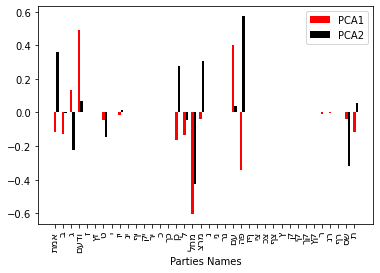

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbaf4d99910>)

In [141]:
norm_low_dim = np.column_stack((vec_1,vec_2))
def plot_low_dim(df):
    width = 0.3  # set column width
    n = df.shape[0]  # number of parties
    names = df_2021_ballots.columns

#     names = [parties_dict_2021[name] for name in list(names)]
    rev_names = [party[::-1] for party in names]
    fig, ax = plt.subplots()  # plt.subplots()
    comp_1 = ax.bar(np.arange(n), list(norm_low_dim[:,0]), width, color='r')
    comp_2 = ax.bar(np.arange(n)+width, list(norm_low_dim[:,1]), width, color='black')

    # ax.set_ylabel('Votes percent')
    ax.set_xlabel('Parties Names')
    # ax.set_title('Votes percent per party 2021')
    ax.set_xticks(np.arange(n),)
    ax.set_xticklabels(rev_names,rotation=90)
    ax.legend((comp_1[0], comp_2[0]), ('PCA1', "PCA2"))
    
    plt.show()

    return fig, ax

plot_low_dim(norm_low_dim)

The most dominnating parties for the first PCA:
הרשימה המשותפת, הליכוד ויש עתיד
The most dominnating parties for the seconed PCA:
עבודה, ליכוד ויש עתיד

# b

<function matplotlib.pyplot.show>

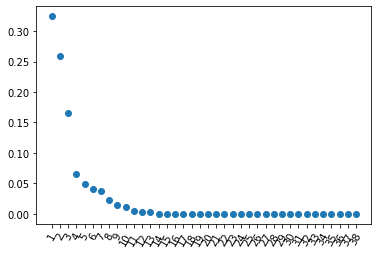

In [142]:
pca = PCA(n_components = df_2021_ballots.shape[1])
pca.fit(df_2021_ballots)
var_ratio = pca.explained_variance_ratio_
plt.scatter(np.arange(var_ratio.size), var_ratio)
plt.xticks(np.arange(0,var_ratio.size),np.arange(0,var_ratio.size)+1)
plt.xticks(rotation=60)
plt.show

<function matplotlib.pyplot.show>

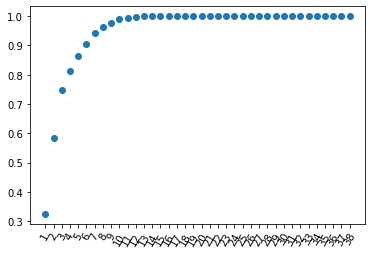

In [143]:
plt.scatter(np.arange(var_ratio.size), np.cumsum(var_ratio))
plt.xticks(np.arange(0,var_ratio.size),np.arange(0,var_ratio.size)+1)
plt.xticks(rotation=60)
plt.show

From the plots we can see that the first 5 components explain around 90% of the variance and the first 10 components explain all most all of the variance. So we would reccomened to reduce the dimenson to 5-7, and it will explain 90%-95% of the variance.

# 2

# a

In [144]:
df_2020_raw = pd.read_csv(io.BytesIO(uploaded['election_2020.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
df_2020_raw = df_2020_raw.drop("מעטפות חיצוניות")
nine_big = ["טב", "ל", "אמת", "ג", "שס", "ודעם", "פה", "מחל", "נץ"]
df_2020 = df_2020_raw.loc[:,nine_big]
df_2020["מרצ"] = df_2020["אמת"]*0.5
df_2020["אמת"] = df_2020["אמת"]*0.5
df_2020["עם"] = df_2020["ודעם"]*0.4
df_2020["ודעם"] = df_2020["ודעם"]*0.6
df_2020["ת"] = df_2020["מחל"]*0.167
df_2020["מחל"] = df_2020["מחל"]*0.833
df_2020["כן"] = df_2020["פה"]*0.333
df_2020["פה"] = df_2020["פה"]*0.667
df_2020["ב"] = df_2020["טב"]*0.6
df_2020["ט"] = df_2020["טב"]*0.4
df_2020["ט"] = df_2020["ט"]+df_2020["נץ"]
df_2020 = df_2020.drop(columns = "נץ")
df_2020 = df_2020.drop(columns = "טב")
df_all = pd.concat([over_trsh_21.sort_index(),df_2020.sort_index()])
df_all = df_all.drop('רותם')
df_all = df_all.drop('פלך')
df_all = df_all.drop('באר מילכה')
df_all = df_all.drop('מעלה שומרון')
df_all = df_all.drop('עמיחי')

In [145]:
df_all_norm = df_all.div(df_all.sum(axis=1),axis =0)

# b

In [146]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_all_norm)

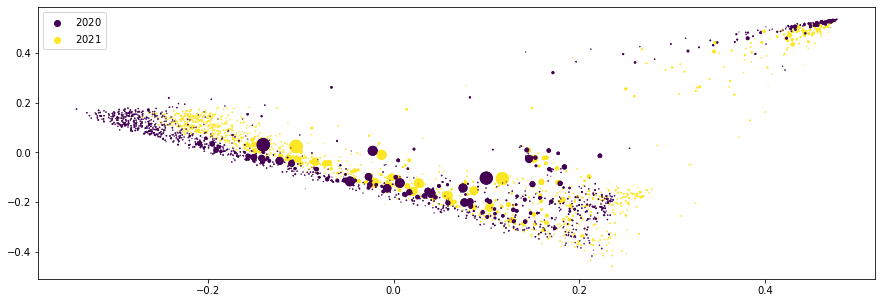

In [147]:
color = np.append(np.repeat(2021,1211),np.repeat(2020,1211))
size = df_2021_raw.loc[[x for x in df_2021_raw.sort_index().index if x in df_all.index]]["כשרים"]/df_2021_raw["כשרים"].max()
final_size = size.append(size)
plt.figure(figsize=(15,5))
plt.scatter(X_pca[:,0],X_pca[:,1],s = final_size*250,c = color)
sc = plt.scatter(X_pca[:,0],X_pca[:,1],s = final_size*250,c = color)
plt.legend(*sc.legend_elements())

We can see that the big cities are more around the center, and the small cities are more in the corners.

# c + d

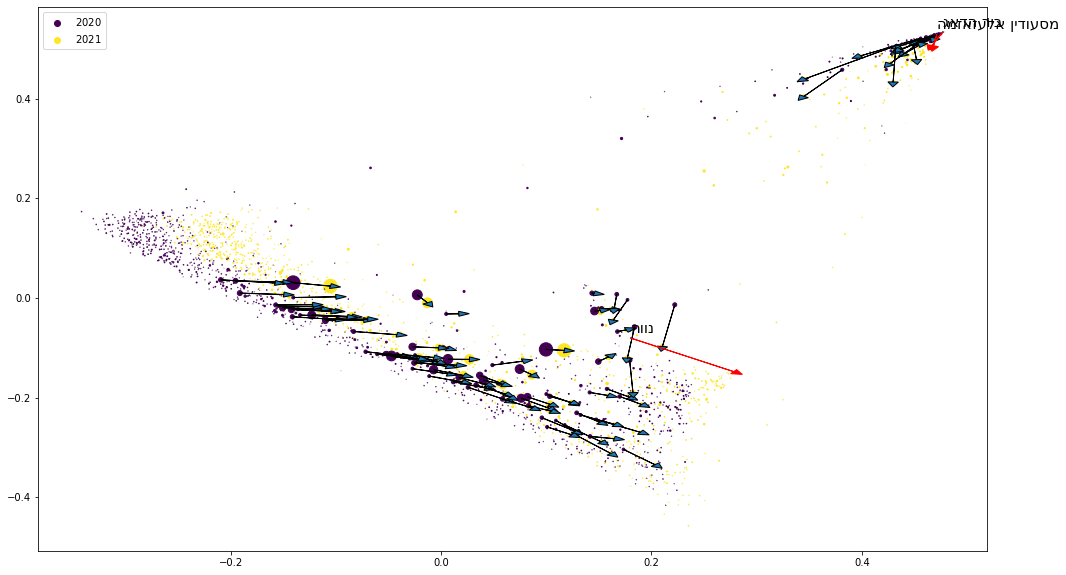

In [148]:
X_pca_df = pd.DataFrame(X_pca)
X_pca_df = X_pca_df.set_index(df_all_norm.index)
per_year = df_all.shape[0]//2
vec_dist = (df_all_norm.iloc[:per_year]-df_all_norm.iloc[per_year:]).pow(2).sum(axis=1)
biggest_change = vec_dist.nlargest(3)
biggest_change

plt.figure(figsize=(17,10))
check = plt.scatter(X_pca_df.iloc[:,0],X_pca_df.iloc[:,1],s = final_size*300,c = color, label = ["2021", "2020"])
plt.legend(*check.legend_elements())

big_citys = df_2020_raw.loc[df_2020_raw["כשרים"]>10000].index
for city in big_citys:
    xy_start = X_pca_df.loc[city].iloc[1,:]
    dist = X_pca_df.loc[city].iloc[0,:] - xy_start
    plt.arrow(xy_start[0], xy_start[1], dist[0], dist[1], 
            width = 0.00001, head_width=0.01, head_length=0.01)
    
for city in biggest_change.index:
    xy_3big_start = X_pca_df.loc[city].iloc[1,:]
    dist_big = X_pca_df.loc[city].iloc[0,:] - xy_3big_start
    plt.arrow(xy_3big_start[0], xy_3big_start[1], dist_big[0], dist_big[1], 
            width = 0.00001, head_width=0.01, head_length=0.01, color = "red")
    plt.text(xy_3big_start[0], xy_3big_start[1]+0.01, city[::-1],size = 15, color = "black")
plt.show()

We can see that thers an increase from 2020 to 2021 in the x axis for most of the citys and specially for the big citys, theres a small decrease for the y axis. theres an exception for citys in the right and up corner where the y axis had a decrease from 2020 to 2021.

# d

In [149]:
biggest_change

שם ישוב
נווה                1.009091
ביר הדאג            0.667415
מסעודין אלעזאזמה    0.623461
dtype: float64

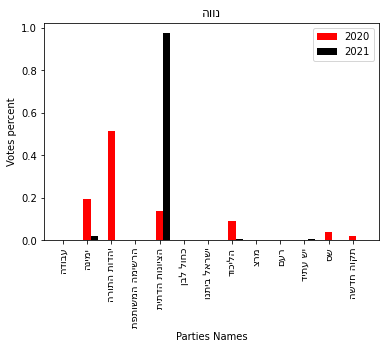

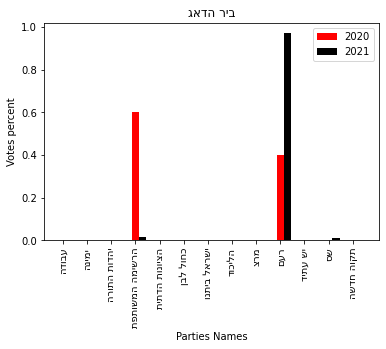

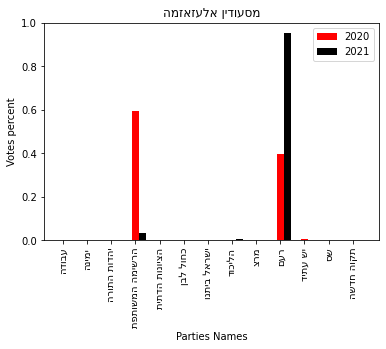

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbaf2f73a10>)

In [150]:
def old_vs_new(city , city_2):
    width = 0.3  # set column width 
    votes = city.div(city.sum())  # total votes for each party
    votes2 = city_2.div(city_2.sum())
    n = len(votes)  # number of parties
    names = votes.keys()
    # df = votes.sort_values()
    # df_2.sort_values()
    names = [parties_dict_2021[name] for name in list(names)]
    rev_names = [party[::-1] for party in names]
    fig, ax = plt.subplots()  # plt.subplots()

    bar_2020 = ax.bar(np.arange(n), list(votes), width, color='r')
    bar_2021 = ax.bar(np.arange(n)+width, list(votes2), width, color='black')
    ax.set_ylabel('Votes percent')
    ax.set_xlabel('Parties Names')
    ax.set_title(f"{city.name[::-1]}")
    ax.set_xticks(np.arange(n),)
    ax.set_xticklabels(rev_names,rotation=90)
    ax.legend((bar_2020[0], bar_2021[0]), ("2020", "2021"))
    plt.show()

    return fig, ax

old_vs_new(df_2020.loc["נווה"].sort_index(), over_trsh_21.loc["נווה"].sort_index())
old_vs_new(df_2020.loc["ביר הדאג"].sort_index(), over_trsh_21.loc["ביר הדאג"].sort_index())
old_vs_new(df_2020.loc["מסעודין אלעזאזמה"].sort_index(), over_trsh_21.loc["מסעודין אלעזאזמה"].sort_index())

In [151]:
over_trsh_21.loc["נווה"]

אמת       0
מרצ       0
ג         0
עם        0
ת         0
ודעם      0
ב         5
ט       277
ל         0
מחל       1
פה        1
כן        0
שס        0
Name: נווה, dtype: int64

there were some major differnece in the votings:
In "נווה" in 2021 almost all of the votes went to "הציונות הדתית" insted to the other partirs.
In "ביר הדאג" and "מסעודין אלעזאזמה" there was the same ditribution of the votes, in 2020 votes went around 60% to "הרשימה המשותפת" and around 40% to "רעם", but in 2021 almost all of the votes went to "רעם".